**Title:** Proposal for a classification model predicting knowledge status of users

**Introduction:**

We are using a dataset called User Knowledge Modeling that classifies the students' knowledge of Electrical DC Machines. 
It uses an intuitive knowledge classifier to create four classes: Very low (0-50), Low (122), Middle (129), and High (130). 
This data provides weighted differences for dependent data users in different domains to create a better user modeling system. **I feel like this is not background information but dataset description?**

Question: Can we use STG, SCG and PEG as input values to build a good enough classification model 
that can predict the knowledge level of future users?


These values for the classes are determined from five attributes: 
the degree of study time for goal object materials (STG), 
the degree of repetition number of user for goal object materials (SCG), 
the degree of study time of user for related objects with goal object (STR), 
the exam performance of user for related objects with goal object (LPR), 
and the exam performance of user for goal objects (PEG).

**Preliminary exploratory data analysis:**

In [12]:
# libraries used

library(tidyverse)
library("readxl")
library(tidymodels)
     

## load the file
# this demonstrates that the dataset can be read from the web into R 

url <- "https://archive.ics.uci.edu/static/public/257/user+knowledge+modeling.zip"
download.file(url, "user_data.zip")
unzip("user_data.zip")
user_data_old <- read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls",sheet=2)
head(user_data_old)

New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low,NA,NA,"STG (The degree of study time for goal object materails),"
0.08,0.08,0.10,0.24,0.90,High,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,STR (The degree of study time of user for related objects with goal object)
0.10,0.10,0.15,0.65,0.30,Middle,NA,NA,LPR (The exam performance of user for related objects with goal object)
0.08,0.08,0.08,0.98,0.24,Low,NA,NA,PEG (The exam performance of user for goal objects)
0.09,0.15,0.40,0.10,0.66,Middle,NA,NA,UNS (The knowledge level of user)


In [2]:
# create the users df, which contains all the useful columns only

users <- user_data_old |> select(STG:UNS)
head(users)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


**This data is in tidy format:**

A tidy data frame satisfies the following three criteria:
1. Each row is a single observation.
2. Each column is a single variable, for eample, STG SCG STR and so on.
3. Each value is in a single cell (i.e., its entry in the data frame is not shared with another value).

Our dataset meets the above criteria.

In [15]:
# Split the data into training and test sets

user_split <- initial_split(users, prop = 0.75, strata = UNS)
user_train <- training(user_split)
user_test <- testing(user_split) 

In [16]:
# The number of observations in each class in the training set
# We make sure there is no extreme class imbalance (see 5.7.2 in textbook).

n_class <- user_train |> group_by(UNS)|> summarize(count=n())
n_class

UNS,count
<chr>,<int>
High,48
Low,62
Middle,65
very_low,18


In [14]:
# The means and standard deviations of the predictor variables
# Since there are no NAs in these summarize tables, 
# It also means there are no NAs in the dataset

# Furthermore, since both means and standard deviations of predictors are on comparable scales,
# we do not need to do any centering or scaling.

means <- user_train |> summarize(across(c(STG,SCG,PEG), mean))
means

sds <- user_train |> summarize(across(c(STG,SCG,PEG), sd))
sds

STG,SCG,PEG
<dbl>,<dbl>,<dbl>
0.3868021,0.3547604,0.4591302


STG,SCG,PEG
<dbl>,<dbl>,<dbl>
0.2154609,0.2173274,0.2496635


In [7]:
# put all 3 predictors into one column to be able to compare subplots containing their distributions

user_train_wide <- user_train |> select(STG, SCG, PEG) |>
                pivot_longer(cols=c(STG,SCG,PEG),names_to="predictors",values_to="values")
head(user_train_wide)


predictors,values
<chr>,<dbl>
STG,0.08
SCG,0.08
PEG,0.90
STG,0.00
SCG,0.00
PEG,0.85


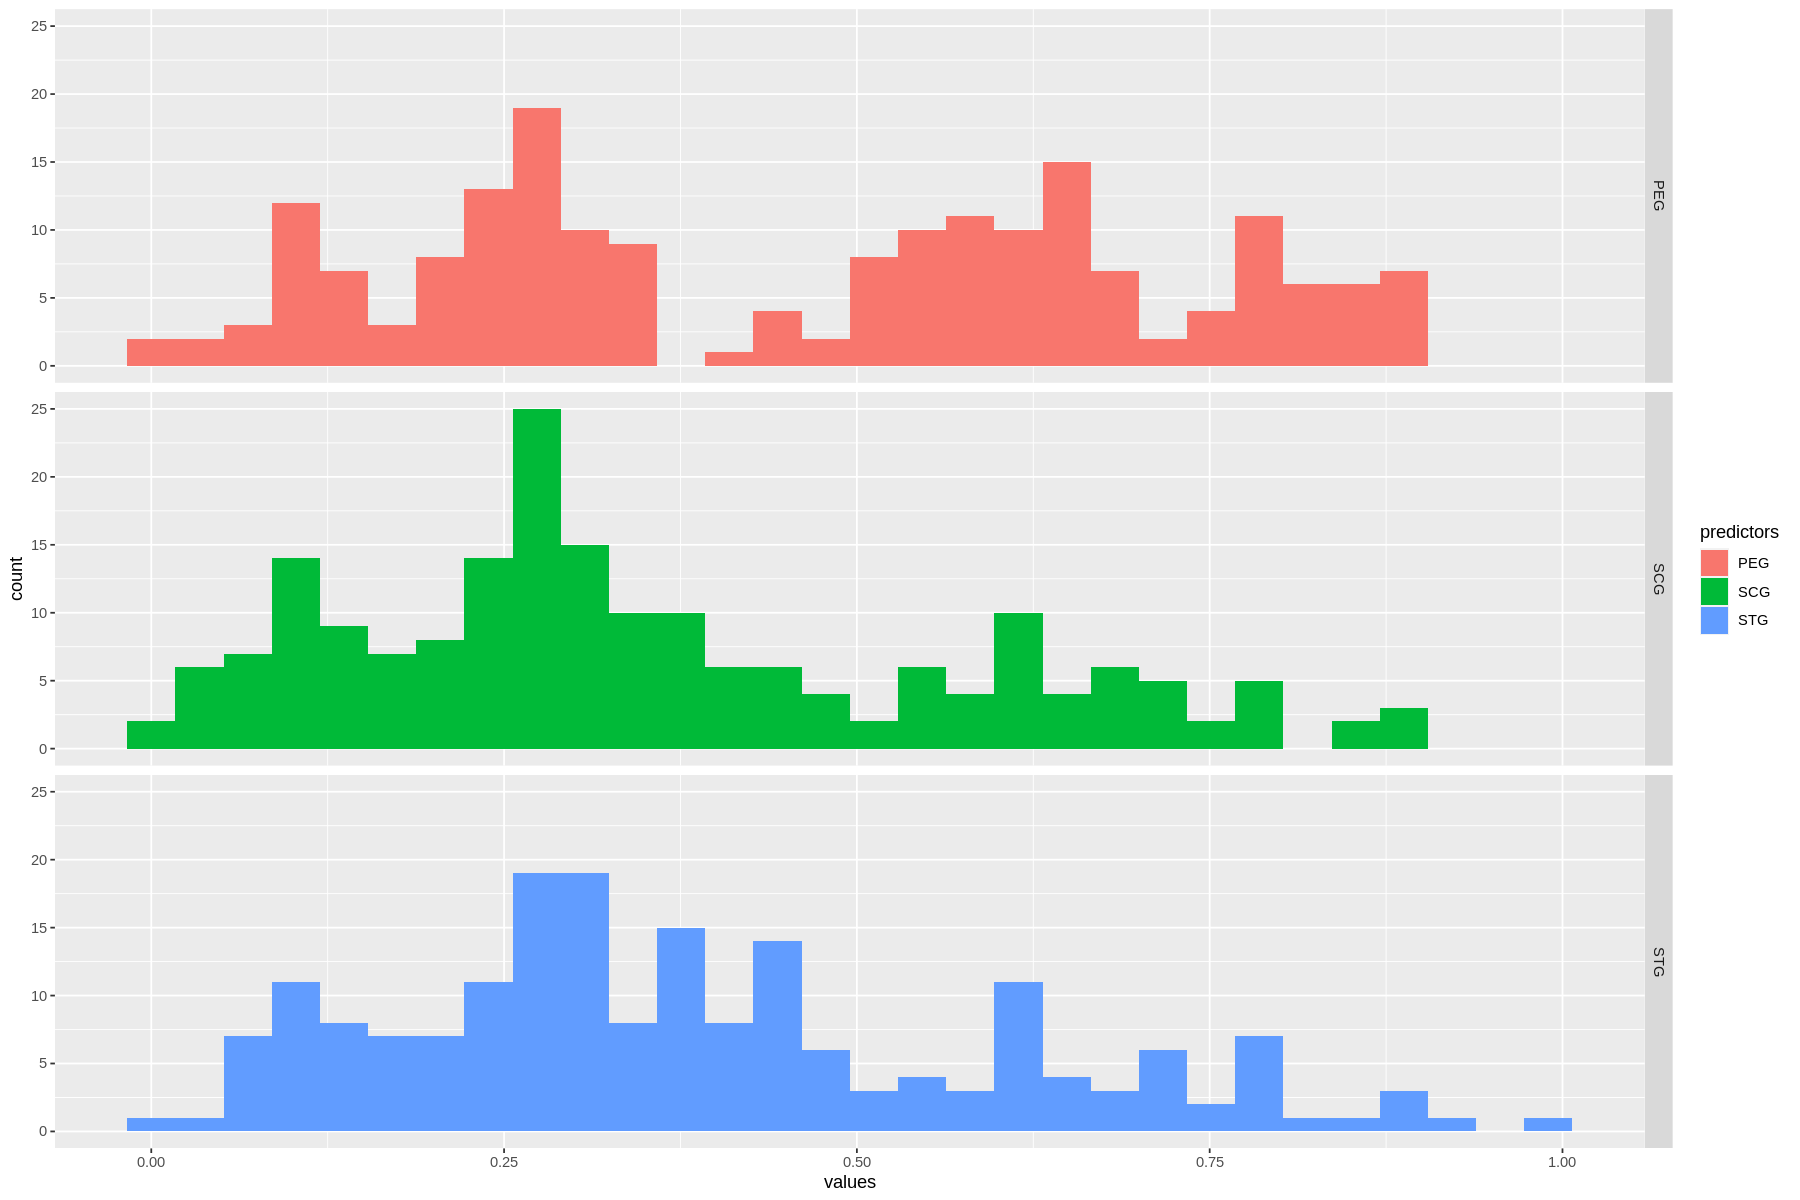

In [18]:
# Distributions of the three predictors !!!!!!! How can this be helpful? !!!!!
#Answer:First, it can help us see the size distribution of these three predicted quantities with our UNS values, 
#which in turn can help us determine whether they have a certain relationship and help us get more precise conclusions.
# we make the three prdictors,it can make the new 
dist_pred <- user_train_wide |> ggplot(aes(x=values, fill=predictors))+
                                geom_histogram(bins=30)+
                                facet_grid(rows=vars(predictors))
dist_pred

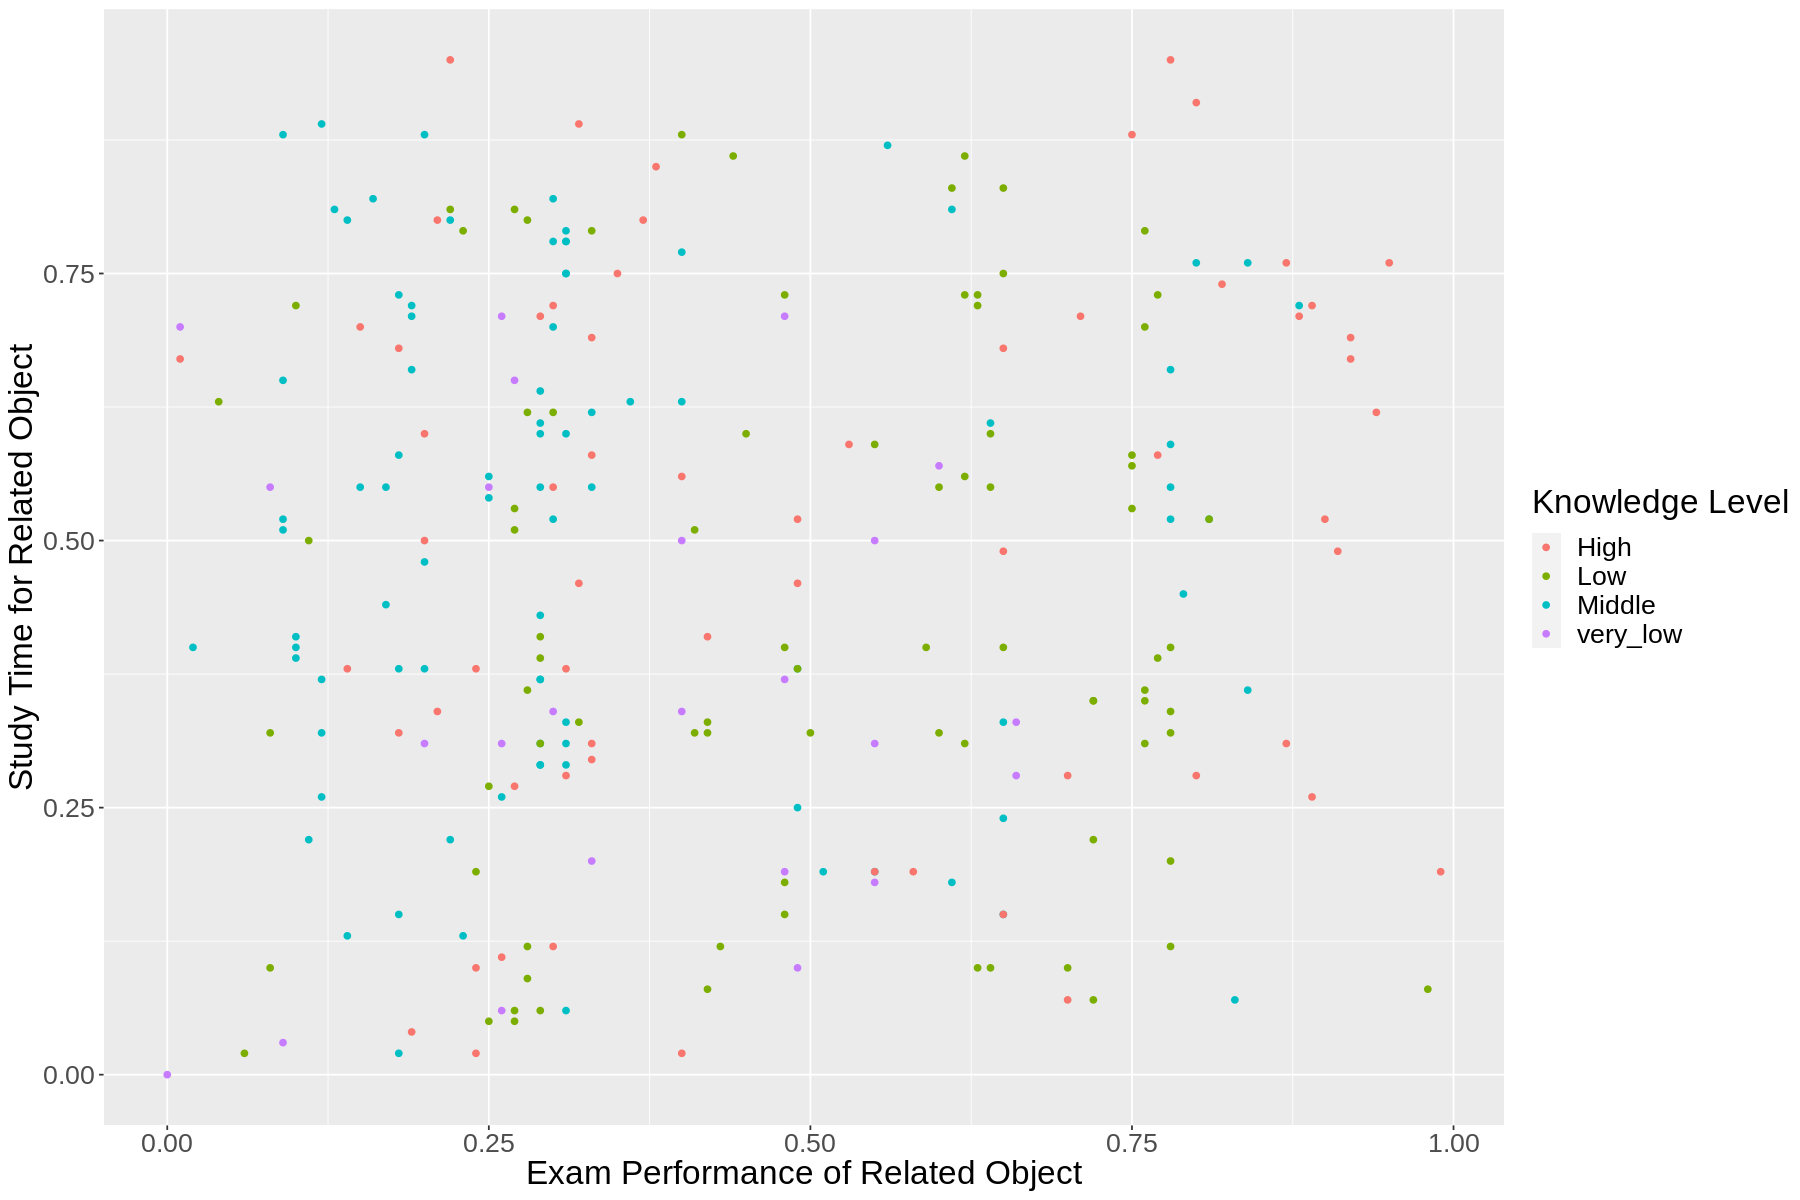

In [17]:
# Scatter plot of STR vs LPR to see if the two variables that we exclude from our predictors
# have some power to predict UNS.
# It seems that they don't have much power to predict UNS,
# which may indicate our decision of excluding these two variables from predictors is correct.

library(repr)
options(repr.plot.width=15, repr.plot.height=10)
rel_point <- users |> ggplot(aes(x=LPR,y=STR,colour=UNS))+
                        geom_point()+
                        labs(x="Exam Performance of Related Object", y="Study Time for Related Object",
                            colour="Knowledge Level")+
                        theme(text=element_text(size=20))
rel_point

**Methods and General steps for data analysis**

1. Define the target value: UNS.

2. Select the variables: STG, SCG, PEG.

3. Use the initial_split function to split the data into a training and test set.

4. Split up the training data for cross-validation using the vfold_cv function.

4. Create a recipe

4. Build the k-nearest model with neighbours  = tune() 

6. Add the recipe and model specification to a workflow(), and use the tune_grid function on the          train/validation splits to estimate the classifier accuracy for a range of K values.

8. Plot neighbours vs accuracy estimate to find the best K value that yields a high accuracy estimate and doesn’t change much if you change K to a nearby value.

9. Use the best K to make a new model specification and retrain the classifier

10. Evaluate the accuracy on the test set.



**Visualization for the results:**

1.Neighbours vs accuracy estimate (scatter plot + line plot) to show chosen K value

2.Bar chart for classes (very low, low, middle, high)  vs. accuracy (counts of incorrect values) to see success of model

3.A histogram plot for each of the three predictors with filling the bars by UNS

**Expected outcomes and significance:**


1.What do you expect to find?

Answer:We expect to find that STG, SCG and PEG can predict the UNS of a new student with pretty good accuracy.

2.What impact could such findings have?

Answer:Our findings can help employ people. For example, if the people a company needs require some understanding of certain materials, we can evaluate their knowledge level by surveying their study time for the materials, repetition frequencies for the materials and their related exam performances.
Our findings can also help students assess the efficiencies of their study strategies and their ability to comprehend the subject.

3.What future questions could this lead to?

Answer:Can more variables such as the method of studying and students’ self evaluation of preparedness increase the accuracy of the classification model?
If we reduce one variable, can we get similar or same results?
